# Modeling by joint Systolic and Diastolic predictors vs End to end model

In [1]:

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np 
import warnings
import sklearn

from scipy.stats import uniform, loguniform

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from IPython.display import display
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute._base import SimpleImputer as Imputer 
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
   
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef as mcc

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### Import high Diastolic and Systolic models

In [2]:
from joblib import dump, load
DiastolicClf = load('DiastolicClf.joblib')
SystolicClf = load('SystolicClf.joblib')

### Import training set to determine best probability thresholds

In [3]:
#!pip install pickle5
import pickle5 as pickle
with open("HT_train.pkl","rb") as fh:
    df_valid = pickle.load(fh)

#df_valid = pd.read_pickle("HT_train.pkl") 

In [4]:
Z_valid = df_valid.drop(['HyperSystolic','HyperDiastolic','Hypertensive'], axis = 1)
w_Svalid = df_valid['HyperSystolic']
w_Dvalid = df_valid['HyperDiastolic']
w_valid = df_valid['Hypertensive']

In [5]:
w_Dvalid_prob = DiastolicClf.predict_proba(Z_valid)[:,1]
w_Svalid_prob = SystolicClf.predict_proba(Z_valid)[:,1]

### Determine best probability thresholds

We loop over high diastolic and high systolic blood pressure to determine the best probability thresholds.

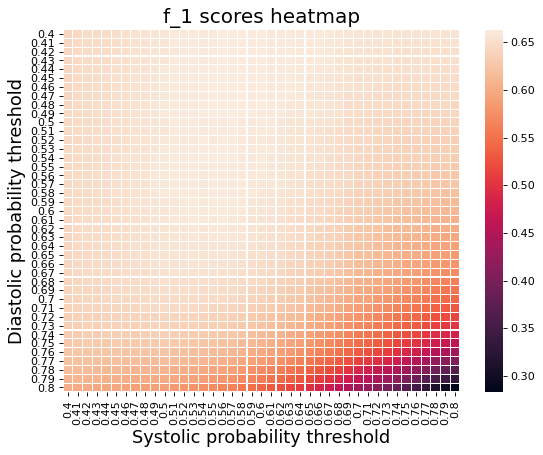

In [6]:
steps = 41
f1_scores = np.zeros((steps,steps))
max_score = 0
Sspace = np.linspace(0.4,0.8,steps).round(3)
Dspace = np.linspace(0.4,0.8,steps).round(3)

for S_idx, S_bdry in enumerate(Sspace):
    for D_idx, D_bdry in enumerate(Dspace):
        w_Svalid_pred = (w_Svalid_prob > S_bdry).astype(int)
        w_Dvalid_pred = (w_Dvalid_prob > D_bdry).astype(int)
        w_valid_pred = np.max(np.stack([w_Svalid_pred,w_Dvalid_pred]),axis = 0)
        f1_scores[S_idx,D_idx] = f1_score(w_valid,w_valid_pred)
        if f1_scores[S_idx,D_idx] > max_score:
            best_bdry = (S_bdry,D_bdry)
            best_idx = (S_idx,D_idx)
            max_score = f1_scores[S_idx,D_idx] 

plt.figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(f1_scores, linewidth=0.1,xticklabels = Sspace,yticklabels = Dspace)
plt.title('f_1 scores heatmap', fontsize = 18)
plt.xlabel('Systolic probability threshold', fontsize = 16)
plt.ylabel('Diastolic probability threshold', fontsize = 16)
plt.show()



In [7]:
print(f'The best choice of probability threshold is {best_bdry[0]} for the Systolic classifier and {best_bdry[1]} for the Diastolic classifier.')

print(f'The best choice of probability threshold leads to an f1 score on the training set of {f1_scores[best_idx]:.4}')

The best choice of probability threshold is 0.46 for the Systolic classifier and 0.57 for the Diastolic classifier.
The best choice of probability threshold leads to an f1 score on the training set of 0.6634


We will construct a predictor based on the above best boundary thresholds

In [8]:
def JointSystolicDiastolicPredictor(best_bdry,SystolicClf,DiastolicClf,Z):
    D_prob = DiastolicClf.predict_proba(Z)[:,1]
    S_prob = SystolicClf.predict_proba(Z)[:,1]
    
    S_pred = (S_prob > best_bdry[0]).astype(int)
    D_pred = (D_prob > best_bdry[1]).astype(int)
    
    
    return np.max(np.stack([S_pred, D_pred]),axis = 0)
    

Import the test set and the end-to-end classifier.

In [9]:
with open("HT_test.pkl","rb") as fh:
    df_test = pickle.load(fh)


HypertensiveClf = load('hypertensiveClf.joblib')

#df_test = pd.read_pickle("HT_test.pkl")

Z_test = df_test.drop(['HyperSystolic','HyperDiastolic','Hypertensive'], axis = 1) 
w_test = df_test['Hypertensive']

Now let us compare the end to end classifier to the joint classifier.

In [10]:
w_ht_pred = HypertensiveClf.predict(Z_test)
f1_ht = f1_score(w_test,w_ht_pred)

w_joint_pred = JointSystolicDiastolicPredictor(best_bdry, SystolicClf, DiastolicClf, Z_test)
f1_joint = f1_score(w_test,w_joint_pred)

print(f'The f_1 score for the end to end classifier on the test set is {f1_ht:.4}.')
print(f'The f_1 score for the joint classifier on the test set is {f1_joint:.4}.')

The f_1 score for the end to end classifier on the test set is 0.6643.
The f_1 score for the joint classifier on the test set is 0.665.


The joint classifier slightly outperforms the end to end classifier!